<!--HEADER-->
[*Notas sobre modelagem da epidemia de Covid-19*](https://github.com/rmsrosa/modcovid19) / [*IM-UFRJ*](https://www.im.ufrj.br).

<!--BADGES-->
<a href="../slides/18.00.Aula-Construindo_Cenarios_e_Pop_Multi_350_social.slides.html" target="_blank"><img align="left" src="https://img.shields.io/badge/local-slides-darkgreen" alt="localslides" title="Local Slides"></a>
&nbsp;

<!--NAVIGATOR-->
[<- O cenário de múltiplos do Pop350: rede residencial](17.00.Aula-Construindo_Cenarios_e_Pop_Multi_350_residencial.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 

---


# O cenário de múltiplos do Pop350: redes sociais

- O objetivo é continuar a criação de cenários que sejam **múltiplos** do cenário `Pop350` visto anteriormente.

- Neste segundo caderno da série, nos ocupamos em gerar as **rede sociais.**

In [1]:
import datetime # date and time tools

import os, sys

import math

import random

import numpy as np

import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns

import io, base64
from IPython.display import Image, HTML

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import episiming

In [3]:
sns.set_style("darkgrid")

In [4]:
dt_string = datetime.datetime.now().strftime("%d/%b/%Y")
print(f"Atualização mais recente do kernel: {dt_string}")

Atualização mais recente do kernel: 28/May/2020


## Multiplicando a distribuição da população do Pop350

- Partimos da região, utilizada anteriormente, com 350 indivíduos divididos em 50 blocos.

- Permitimos cópias desse bloco nas duas direções espaciais.

- E permitimos multiplicação "por escalar" do número de habitantes em cada bloco ("cópias verticais")

### Região original de 350 indivíduos

São $5 x 10 = 50$ blocos, distribuidos em um espaço bidimensional, cada um com uma população dada pela matriz a seguir:

In [5]:
regiao_350_lista = \
    [
        [16, 11, 0, 0,  0,  6,  4,  8,  8,  6],
        [10, 12, 12, 6, 8, 9,  8,  6,  7,  5],
        [0, 10, 14, 10, 12,  8,  0,  0,  6,  8],
        [0, 12, 10, 14, 11,  9,  0,  0,  5,  7],
        [9, 11, 0, 12, 10,  7,  8,  7,  8, 0]
    ]

regiao_350 = np.array(regiao_350_lista)

### Multiplicando a região original

- Unimos cópias dos blocos nas direções espaciais.

- Multiplicamos uniformemente a população de cada bloco.

In [6]:
x_vezes = 3
y_vezes = 2
pop_vezes = 2

aux = []
for l in regiao_350_lista:
    aux.append( x_vezes * l )

regiao_multi_350 = pop_vezes * np.array( y_vezes * aux)

### Total da população

In [7]:
num_pop = regiao_multi_350.sum()
print(num_pop)

4200


### Visualização


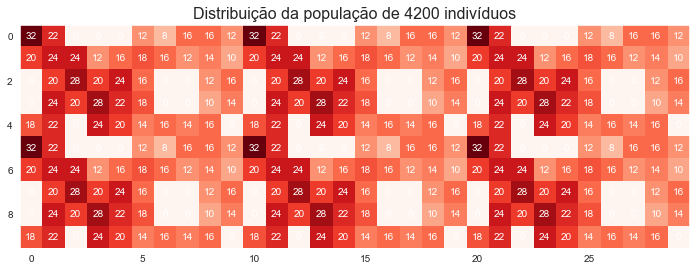

In [8]:
plt.figure(figsize=(12,5))
plt.imshow(regiao_multi_350, cmap='Reds', interpolation='nearest')
N, M = regiao_multi_350.shape
for i in range(N):
    for j in range(M):
        plt.text(j, i, regiao_multi_350[i, j],
                 ha="center", va="center", color="w")
plt.grid(False)
plt.title(f'Distribuição da população de {regiao_multi_350.sum()} indivíduos', fontsize=16)
plt.show()

## Distribuição dos indivíduos por tamanho de residência

- Fazemos, agora, a distribuição dos indivíduos por residência.

- Aqui, utilizamos o que já foi feito no *notebook* anterior.

### Censo residencial

In [9]:
censo_residencial = np.array([.21, .26, .20, .17, .08, .04, .02, 0.02])
media = sum([censo_residencial[j]*(j+1) for j in range(len(censo_residencial))])
print(f'Casas de 1 a {len(censo_residencial)} moradores')
print(f'Com densidades de probabilidades {censo_residencial}, respectivamente')
print(f'Total: {sum(censo_residencial)}')
print(f'Média de moradores por residência: {media:.2f}')

Casas de 1 a 8 moradores
Com densidades de probabilidades [0.21 0.26 0.2  0.17 0.08 0.04 0.02 0.02], respectivamente
Total: 1.0
Média de moradores por residência: 2.95


### Funções de distribuição das residências

In [10]:
def distribui_residencias_bloco(num_pop_bloco, censo_residencial, modo = 's'):
    '''
    Distribui indivíduos por tamanho de residência, seguindo uma lista com o censo 
    de distribuição dada.
    
    A sobra é distribuida seguinda uma ordem definida pelo argumento `modo`.
    
        Se `modo == 'c'` ("crescente"), a distribuição é do menor 
        para o maior tamanho de residência.

        Se `modo == 'd'` ("decrescente"), a distribuição é do maior 
        para o menor tamanho de residência.
        
        Se `modo == 's'` ("sorteado"), a distribuição é em ordem aleatório.
    '''
    distrib_res_bloco = [int(num_pop_bloco*censo_residencial[k]/(k+1)) 
                                      for k in range(len(censo_residencial))]
    distrib_pop_bloco = [distrib_res_bloco[k]*(k+1) 
                              for k in range(len(censo_residencial))]
    total_bloco = sum(distrib_pop_bloco)
    sobra = num_pop_bloco -  total_bloco
    if sobra > 0:
        distrib_res_bloco, distrib_pop_bloco, sobra \
            = distribui_sobra_bloco(distrib_res_bloco, sobra, modo)
    return distrib_res_bloco, distrib_pop_bloco, sobra

In [11]:
def distribui_sobra_bloco(distrib_res_bloco, sobra, modo = 's'):
    '''
    Distribui a sobra de indivíduos por tamanho de residência.
    
    A sobra é distribuida seguinda uma ordem definida pelo argumento `modo`.
    
        Se `modo == 'c'` ("crescente"), a distribuição é do menor 
        para o maior tamanho de residência.

        Se `modo == 'd'` ("decrescente"), a distribuição é do maior 
        para o menor tamanho de residência.
        
        Se `modo == 's'` ("sorteado"), a distribuição é em ordem aleatório.
    '''
    
    if modo == 'c':
        k_indices = range(1, len(distrib_res_bloco)+1)
    elif modo == 'd':
        k_indices = range(len(distrib_res_bloco), 0, -1)
    else:
        k_aux = list(range(1, len(distrib_res_bloco)+1))
        np.random.shuffle(k_aux)
        k_indices = iter(k_aux)

    for k in k_indices:
        if sobra >= k:
            distrib_res_bloco[k-1] += 1
            sobra -= k
    distrib_pop_bloco = [distrib_res_bloco[k]*(k+1) 
                        for k in range(len(distrib_res_bloco))]
    if sobra > 0:
        distrib_res_bloco, distrib_pop_bloco, sobra \
            = distribui_sobra_bloco(distrib_res_bloco, sobra, modo)
    return distrib_res_bloco, distrib_pop_bloco, sobra

In [12]:
def distribui_residencias_e_individuos(regiao, censo_residencial, modo = 's'):
    N, M = regiao.shape
    distrib_res_regiao = []
    distrib_pop_regiao = []
    for i in range(N):
        aux_res = []
        aux_pop = []
        for j in range(M):
            distrib_res_bloco, distrib_pop_bloco, sobra \
                = distribui_residencias_bloco(regiao[i, j], censo_residencial, modo)
            aux_res.append(distrib_res_bloco)
            aux_pop.append(distrib_pop_bloco)
            assert(sobra == 0), f'Não foi possível alocar toda a população do bloco ({i}, {j})'
        distrib_res_regiao += aux_res
        distrib_pop_regiao += aux_pop
    return distrib_res_regiao, distrib_pop_regiao

### Aplicando a função de distribuição em toda a região 

In [13]:
distrib_res_regiao, distrib_pop_regiao \
    = distribui_residencias_e_individuos(regiao_multi_350, censo_residencial, 's')

### Analisando o resultado

In [14]:
print(f'Total de blocos: {len(distrib_res_regiao)}')
total_residencias = sum([sum(l) for l in distrib_res_regiao])
print(f'Total de residências: {total_residencias}')
total_populacao = sum([sum(l) for l in distrib_pop_regiao])
print(f'Total da população: {total_populacao}')
print(f'Média de moradores por residência: {total_populacao/total_residencias:.2f}')
distribuicao_residencias = [0 for j in range(len(distrib_res_regiao[0]))]
distribuicao_populacao = [0 for j in range(len(distrib_res_regiao[0]))]
for distrib_bloco in distrib_res_regiao:
    for j in range(len(distribuicao_residencias)):
        distribuicao_residencias[j] += distrib_bloco[j] 
        distribuicao_populacao[j] += (j+1)*distrib_bloco[j]
print('Total da distribuição de residências por tamanho:')
print(f'   {distribuicao_residencias}')
print('Total da distribuição da população por tamanho da residência:')
print(f'   {distribuicao_populacao}')
print(f'Total da população por outra contagem: {sum(distribuicao_populacao)}')
print('Distribuição do número de residências por tamanho, dos primeiros blocos:')
for l in range(10):
    print(f'   {distrib_res_regiao[l]}')

Total de blocos: 300
Total de residências: 2083
Total da população: 4200
Média de moradores por residência: 2.02
Total da distribuição de residências por tamanho:
   [1011, 569, 257, 104, 57, 40, 21, 24]
Total da distribuição da população por tamanho da residência:
   [1011, 1138, 771, 416, 285, 240, 147, 192]
Total da população por outra contagem: 4200
Distribuição do número de residências por tamanho, dos primeiros blocos:
   [7, 5, 2, 1, 1, 0, 0, 0]
   [5, 3, 1, 0, 0, 0, 0, 1]
   [0, 0, 0, 0, 0, 0, 0, 0]
   [0, 0, 0, 0, 0, 0, 0, 0]
   [0, 0, 0, 0, 0, 0, 0, 0]
   [3, 1, 1, 1, 0, 0, 0, 0]
   [3, 1, 1, 0, 0, 0, 0, 0]
   [4, 2, 1, 0, 1, 0, 0, 0]
   [4, 3, 2, 0, 0, 0, 0, 0]
   [3, 2, 0, 0, 1, 0, 0, 0]


## Posicionamento dos indivíduos

- Agora, posicionamos os indivíduos de acordo com a população em cada bloco e a distribuição da população por tamanho de residência.

- Novamente, utilizamos as funções feitas no *notebook* anterior.

In [15]:
def aloca_residencias_bloco(distrib_res):
    '''
    Aloca as residências por tamanho e as posiciona relativamente ao bloco
    '''
    num_residencias = sum(distrib_res)
    sorteio_lista = list(range(num_residencias**2))
    np.random.shuffle(sorteio_lista) # embaralha "in place"
    sorteio = sorteio_lista[:num_residencias]
    pos_residencias = [( i // num_residencias / num_residencias + 1/2/num_residencias, 
                         i % num_residencias / num_residencias + 1/2/num_residencias )
                       for i in sorteio]
    return pos_residencias

In [16]:
def aloca_individuos_bloco(distrib_res, pos_residencias):
    '''
    Aloca e posiciona os indivíduos em residências
    '''
    num_residencias = sum(distrib_res)
    pos_individuos = []
    res_individuos = []
    m = 0
    n = 0
    for k in range(len(distrib_res)):
        for l in range(1, distrib_res[k]+1):
            res_individuos_l = []
            for i in range(k+1):
                if k == 0:
                    x = pos_residencias[m][0]
                    y = pos_residencias[m][1]
                else:
                    x = pos_residencias[m][0] + np.cos(i*2*np.pi/(k+1))/3/num_residencias
                    y = pos_residencias[m][1] + np.sin(i*2*np.pi/(k+1))/3/num_residencias
                pos_individuos.append((x, y))
                res_individuos_l.append(n)
                n += 1
            res_individuos.append(res_individuos_l)
            m += 1
    return pos_individuos, res_individuos

In [17]:
def aloca_residencias_e_individuos(regiao, censo_residencial):
     
    distrib_res_regiao, distrib_pop_regiao \
        = distribui_residencias_e_individuos(regiao, censo_residencial)

    pos_residencias = []
    pos_individuos = []
    res_individuos = []
    n = 0
    M, N = regiao.shape
    for i in range(N):
        for j in range(M):
            pos_residencias_bloco = aloca_residencias_bloco(distrib_res_regiao[i*M + j])

            pos_individuos_bloco, res_individuos_bloco \
                = aloca_individuos_bloco(distrib_res_regiao[i*M + j], pos_residencias_bloco)
            
            pos_residencias_translated \
                = [(i + pos_residencias_bloco[k][0], j + pos_residencias_bloco[k][1])
                   for k in range(len(pos_residencias_bloco))]
            pos_individuos_translated \
                = [(i + pos_individuos_bloco[k][0], j + pos_individuos_bloco[k][1])
                   for k in range(len(pos_individuos_bloco))]
            res_individuos_translated \
                = [[n + l for l in r] for r in res_individuos_bloco]
            
            pos_individuos += pos_individuos_translated
            pos_residencias += pos_residencias_translated
            res_individuos += res_individuos_translated
    
            n += len(pos_individuos_bloco)
    
    return pos_residencias, pos_individuos, res_individuos

### Posicionando

In [18]:
pos_residencias, pos_individuos, res_individuos \
    = aloca_residencias_e_individuos(regiao_multi_350, censo_residencial)

In [19]:
print(f'Cenário "regiao_multi_350":')
print(f'    número de posições de residências: {len(pos_residencias)}')
print(f'    média de número de indivíduos por residência: {len(pos_individuos)/len(res_individuos):.2f}')
print(f'    número de posições de indivíduos: {len(pos_individuos)}')
print(f'    número de residências com lista de residentes: {len(res_individuos)}')

Cenário "regiao_multi_350":
    número de posições de residências: 2076
    média de número de indivíduos por residência: 2.02
    número de posições de indivíduos: 4200
    número de residências com lista de residentes: 2076


#### Criando a rede residencial

In [20]:
attrib_pos_individuos = {j: pos_individuos[j] for j in range(len(pos_individuos))}

G_r = nx.random_geometric_graph(len(attrib_pos_individuos), 0, pos=attrib_pos_individuos)

for individuos in res_individuos:
    if len(individuos) > 1:
        G_r.add_edges_from([(i,j) for i in individuos for j in individuos])

#### Visualizando a rede residencial

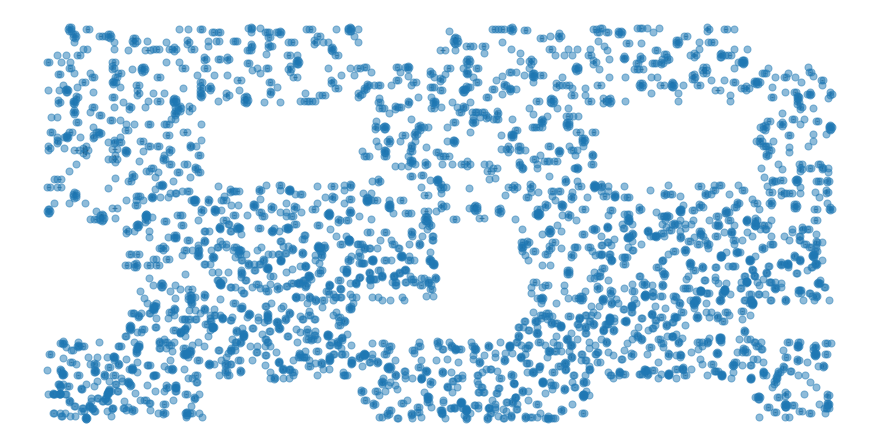

In [21]:
plt.figure(figsize=(12,6))
nx.draw(G_r, pos=attrib_pos_individuos, node_size=50, alpha=0.5)
plt.show()

## Distribuição das idades dos indivíduos

- **Ainda falta implementar**.

- Inicialmente considerei a pirâmide populacional Brasileira.

- Também podemos usar esta pirâmide populacional do cidade do Rio de Janeiro disponível na [Tabela 6407 do IBGE - População residente, por sexo e grupo de idade](https://sidra.ibge.gov.br/tabela/6407#resultado), mas que não diferencia as faixas 60-69, 70-79 e 80 ou mais anos:


| Total | 100,0 |
| --- | --- |
| 0 a 9 anos | 9,4 |
| 10 a 19 anos | 11,9 |
| 20 a 29 anos | 13,2 |
| 30 a 39 anos | 15,5 |
| 40 a 49 anos | 14,2 |
| 50 a 59 anos | 14,0 |
| 60 ou mais | 22,0 |


## Rede de empresas

- Para a distribuição da rede de empresas, vamos, novamente, partir da lista de distribuição feita para a população 350 original.

- A ideia é multiplicá-la, também, nas direções "horizontal" e "vertical".

In [22]:
distribuicao_social_350 = [
    10, 9, 9, 8, 8, 8, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6,
    5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 3, 3,
    4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1
]

### Cópias horizontais:

In [23]:
distribuicao_social_aux = x_vezes*y_vezes*distribuicao_social_350
print(f'Número de locais: {len(distribuicao_social_aux)}')
print(f'Número de trabalhadores nesses locais: {sum(distribuicao_social_aux)}')
print(f'Média de indivíduos por local: {sum(distribuicao_social_aux)/len(distribuicao_social_aux):.2f}')

Número de locais: 360
Número de trabalhadores nesses locais: 1602
Média de indivíduos por local: 4.45


### Cópias verticais

Agora, as cópias verticais não são distribuídas uniformemente, mas de acordo com um perfil.

In [24]:
def multiplicador(h, v, lista = [], n = 0, f = None):
    if not f:
        f = lambda x: x/2
#        f = lambda x: x**(v/h)
#        f = lambda x: x**(0.85)
#        f = lambda x: max(x - 1, 1)
    if n == 0:
        n = h*v
    if lista == []:
        lista = [1 for j in range(h)]
        n -= h
    if n > 0:
        v -= 1
        hp = f(min(n,h))
        hn = int(hp)
        if hp > hn:
            hn += 1
        assert(0 < hp <= hn), 'A função de decaimento deve ser não-crescente e não-nula'
        for j in range(hn):
            if n > 0:
                lista[j] += 1
                n -= 1
        if n > 0:
            lista = multiplicador(h, v, lista, n, f)            
    return lista

[4, 3, 2, 1, 1, 1]


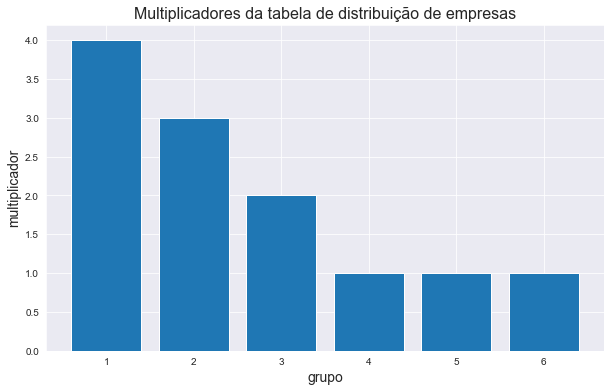

In [25]:
multiplicador_distribuicao = multiplicador(x_vezes*y_vezes,pop_vezes)
print(multiplicador_distribuicao)
plt.figure(figsize=(10,6))
plt.bar(list(range(1,len(multiplicador_distribuicao)+1)), multiplicador_distribuicao)
plt.xlabel('grupo', fontsize = 14)
plt.ylabel('multiplicador', fontsize = 14)
plt.title('Multiplicadores da tabela de distribuição de empresas', fontsize = 16)
plt.show()

In [26]:
distribuicao_social_multi_350 = []
for i in range(x_vezes*y_vezes):
    for j in range(len(distribuicao_social_350)):
        distribuicao_social_multi_350 += [multiplicador_distribuicao[i]*distribuicao_social_350[j]]
distribuicao_social_multi_350.sort(reverse = True)
print(distribuicao_social_multi_350)
print()
print(sum(distribuicao_social_multi_350))

[40, 36, 36, 32, 32, 32, 30, 28, 28, 28, 28, 27, 27, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 21, 21, 21, 21, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 18, 18, 18, 18, 18, 18, 18, 18, 18, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 14, 14, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3

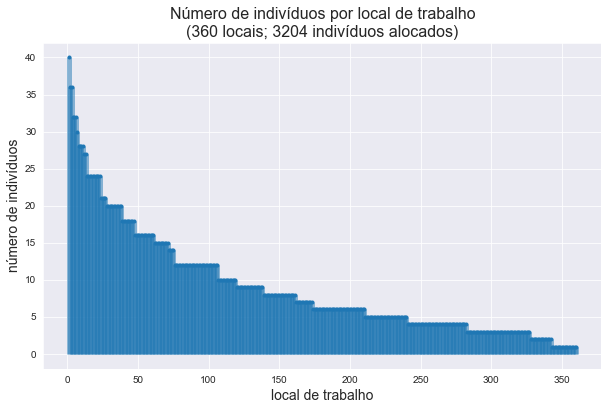

In [27]:
dy = distribuicao_social_multi_350
dx = list(range(1,len(dy)+1))
plt.figure(figsize = (10, 6))
plt.plot(list(range(1,len(distribuicao_social_multi_350)+1)), distribuicao_social_multi_350, '.')
plt.vlines(dx, 0, dy, colors='tab:blue', lw=5, alpha=0.5)
plt.ylabel('número de indivíduos', fontsize = 14)
plt.xlabel('local de trabalho', fontsize = 14)
plt.title('Número de indivíduos por local de trabalho\n'
          + f'({len(dx)} locais; {sum(dy)} indivíduos alocados)',
          fontsize = 16)
plt.show()

In [28]:
#wsc = [1, 10, 20, 50, 100, 200, 500, 1000, 2870]
wsc = [1, 2, 4, 10, 20, 40, 100, 200, 500]
nwsc = []
for j in range(1,len(wsc)):
    conta = 0
    for i in range(len(dy)):
        if wsc[j-1] <= dy[i] < wsc[j]:
            conta += 1
    nwsc.append(conta)
print(nwsc)
print(sum(nwsc))

[18, 60, 163, 81, 37, 1, 0, 0]
360


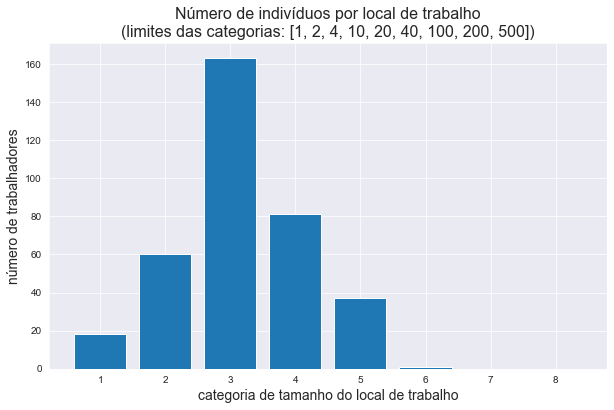

In [29]:
plt.figure(figsize = (10, 6))
plt.bar(list(range(1,len(wsc))), nwsc)
plt.ylabel('número de trabalhadores', fontsize = 14)
plt.xlabel('categoria de tamanho do local de trabalho', fontsize = 14)
plt.title('Número de indivíduos por local de trabalho\n'
          + f'(limites das categorias: {wsc})',
          fontsize = 16)
plt.show()

## Cria rede de empresas

Ainda não estou usando pesos, mas, sobre isso, veja [Stackoverflow: a weighted version of random choice](https://stackoverflow.com/questions/3679694/a-weighted-version-of-random-choice).

In [30]:
membros = dict()
pop_index = list(range(num_pop))

for j in range(len(distribuicao_social_multi_350)):
    individuos_aleatorios = \
        random.sample(pop_index, distribuicao_social_multi_350[j])
    for i in individuos_aleatorios:
        pop_index.remove(i)
    membros.update({j: individuos_aleatorios})

In [31]:
G_e = nx.random_geometric_graph(num_pop, 0, pos = attrib_pos_individuos)
for individuos_aleatorios in membros.values():
    conexoes = [(m,n) for m in individuos_aleatorios 
                for n in individuos_aleatorios if m != n ]
    G_e.add_edges_from(conexoes)

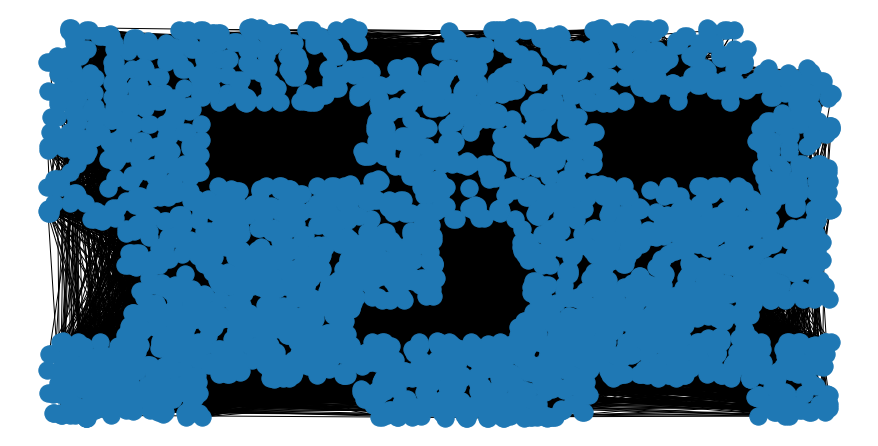

In [32]:
plt.figure(figsize=(12,6))

nx.draw(G_e, pos = attrib_pos_individuos)


## Cenário montado

Memória utilizada pelo grafo: 365.4 Kb
Memória utilizada pela matriz de adjacências: 239.3 Mb
Número de vértices: 5600
Número de arestas: 9892
Número de arestas com peso: 9892.0
Número médio de conexões por indivíduo: 3.5
Número médio de conexões por indivíduo com peso: 3.5


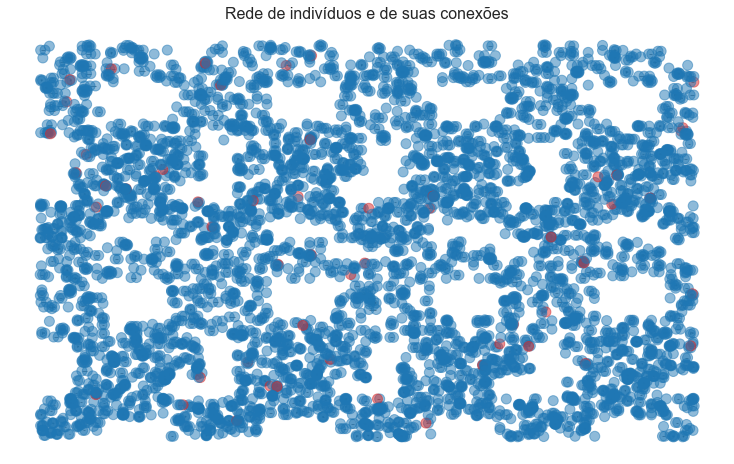

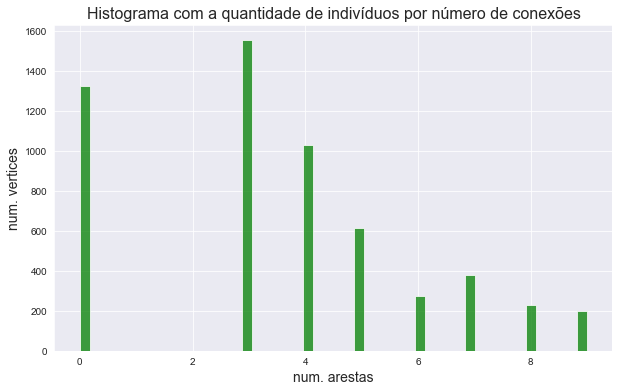

Memória utilizada pelo grafo: 534.3 Kb
Memória utilizada pela matriz de adjacências: 239.3 Mb
Número de vértices: 5600
Número de arestas: 31513
Número de arestas com peso: 31513.0
Número médio de conexões por indivíduo: 11.3
Número médio de conexões por indivíduo com peso: 11.3


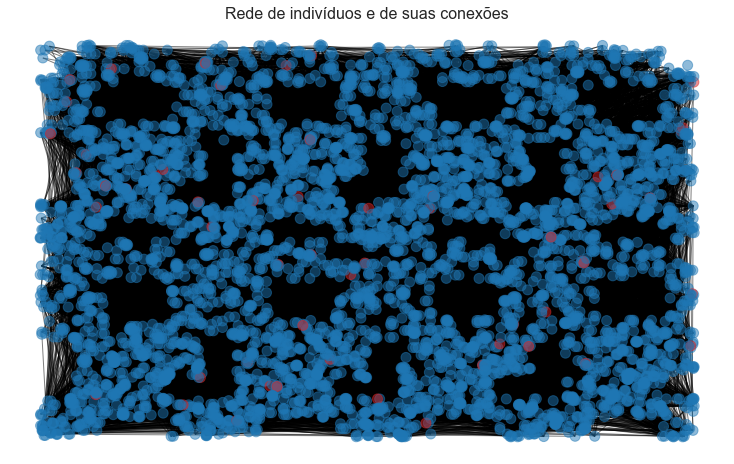

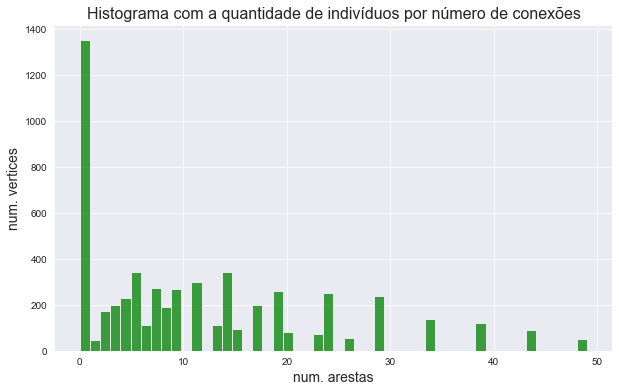

In [33]:
cenario_multi_350 = episiming.cenarios.Multi350(2,4,2)
cenario_multi_350.exibe_redes()

## Simulações

### Dados temporais

In [34]:
num_sim = 10
dt = 1 # primeiro passo
t_0 = 0 # instante initial
num_dt = 60 # inst
dados_temporais = [t_0, dt, num_dt]

### Simulações duplicando as populações 

In [35]:
cenario_1x350 = episiming.cenarios.Multi350(1,1,1)
print(f'População: {cenario_1x350.num_pop}')
%timeit X = cenario_1x350.evolui_jit(dados_temporais, num_sim)

População: 350
164 ms ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [36]:
cenario_2x350 = episiming.cenarios.Multi350(1,2,1)
print(f'População: {cenario_2x350.num_pop}')
%timeit X = cenario_2x350.evolui_jit(dados_temporais, num_sim)

População: 700
713 ms ± 41.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [37]:
cenario_4x350 = episiming.cenarios.Multi350(1,2,2)
print(f'População: {cenario_4x350.num_pop}')
%time X = cenario_4x350.evolui_jit(dados_temporais, num_sim)

População: 1400
CPU times: user 3.22 s, sys: 6.43 ms, total: 3.23 s
Wall time: 3.22 s


In [38]:
cenario_8x350 = episiming.cenarios.Multi350(2,2,2)
print(f'População: {cenario_8x350.num_pop}')
%time X = cenario_8x350.evolui_jit(dados_temporais, num_sim)

População: 2800
CPU times: user 13.2 s, sys: 26.5 ms, total: 13.2 s
Wall time: 13.2 s


In [39]:
cenario_16x350 = episiming.cenarios.Multi350(2,4,2)
print(f'População: {cenario_16x350.num_pop}')
%time X = cenario_16x350.evolui_jit(dados_temporais, num_sim)

População: 5600
CPU times: user 54.8 s, sys: 199 ms, total: 55 s
Wall time: 55.2 s


### Estimativas

| População | Tempo |
| --- | --- |
| 1.000 | ~ 2 segundos
| 10.000 | ~ 2 minutos |
| 100.000 | ~ 2 horas |
| 1.000.000 | ~ 2 semanas |
| 6.000.000 | ~ 1.5 anos  |

- Nesse ritmo "quadrático", ara termos 6 milhões de indivíduos calculados em 1h = 3.600.000 ms, temos que reduzir o cálculo de 1.000 indivíduos para 3.6 ms!

- Ou diminuimos o ritmo, com um código mais eficiente e paralelismo.


<!--NAVIGATOR-->

---
[<- O cenário de múltiplos do Pop350: rede residencial](17.00.Aula-Construindo_Cenarios_e_Pop_Multi_350_residencial.ipynb) | [Página Inicial](00.00-Pagina_Inicial.ipynb) 